In [ ]:
# Cell 5: Path Configuration (Update these to match your Drive/dataset locations)

# X-Sub (default, uncomment to train X-Sub)
Xsub_train_data = '/content/drive/MyDrive/ntu_normalized/xsub_train_data_joint.npy'
Xsub_train_label = '/content/drive/MyDrive/ntu_processed/xsub/train/train_label.pkl'
Xsub_val_data = '/content/drive/MyDrive/ntu_normalized/xsub_val_data_joint.npy'
Xsub_val_label = '/content/drive/MyDrive/ntu_processed/xsub/val/val_label.pkl'

# X-View (use these for X-View)
Xview_train_data = '/content/drive/MyDrive/ntu_normalized/xview_train_data_joint.npy'
Xview_train_label = '/content/drive/MyDrive/ntu_processed/xview/train/train_label.pkl'
Xview_val_data = '/content/drive/MyDrive/ntu_normalized/xview_val_data_joint.npy'
Xview_val_label = '/content/drive/MyDrive/ntu_processed/xview/val/val_label.pkl'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cell 1: Install Dependencies (A100 optimized)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install tensorboardX tqdm pyyaml einops
!pip install torchinfo
!pip install einops

Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 105.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 126.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 16.7 MB/s e

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.7 MB/s eta 0:00:00


# **Imports & Helper Functions**

In [ ]:
# Add these at the top of your first cell
import torch
import numpy as np
from torch.nn.utils import clip_grad_norm_

# Add this after device setup
torch.save({'epoch': 0}, '/tmp/current_epoch.pth')  # For augmentation tracking

In [ ]:
# Cell 2: Setup and Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
import time
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import os
from torchinfo import summary
from torch.cuda import amp
import einops

# Enable TF32 and deterministic mode for A100 GPU
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Data paths (update with your paths)
train_data = '/content/drive/MyDrive/ntu_normalized/xsub_train_data_joint.npy'
val_data   = '/content/drive/MyDrive/ntu_normalized/xsub_val_data_joint.npy'
train_label = '/content/drive/MyDrive/ntu_processed/xsub/train/train_label.pkl'
val_label   = '/content/drive/MyDrive/ntu_processed/xsub/val/val_label.pkl'

# Verify files
print("Train data:", os.path.exists(train_data), "| Val data:", os.path.exists(val_data))
print("Train label:", os.path.exists(train_label), "| Val label:", os.path.exists(val_label))

# Print dataset info
with open(train_label, 'rb') as f:
    sample_names, sample_labels = pickle.load(f)
print(f"Train samples: {len(sample_labels)} | Example label: {sample_labels[0]}")
with open(val_label, 'rb') as f:
    val_names, val_labels = pickle.load(f)
print(f"Val samples: {len(val_labels)} | Example label: {val_labels[0]}")

sample = np.load(train_data, mmap_mode='r')
print("Train data shape (N,C,T,V,M):", sample.shape)
print("One sample min/max:", sample[0].min(), sample[0].max())
print("Unique classes in train:", len(set(sample_labels)))
print("Unique classes in val:", len(set(val_labels)))

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)


Using device: cuda
Train data: True | Val data: True
Train label: True | Val label: True
Train samples: 33383 | Example label: 16
Val samples: 23327 | Example label: 13
Train data shape (N,C,T,V,M): (33383, 3, 300, 25, 2)
One sample min/max: -1.9420302618199796 0.8381361333212642
Unique classes in train: 60
Unique classes in val: 60


# **Enhanced Feeder Class with Advanced Augmentation**

In [ ]:
# Cell 3: Enhanced Feeder Class with Advanced Augmentation
class Feeder(Dataset):
    def __init__(self, data_path, label_path, train=False, debug=False, use_mmap=True):
        self.debug = debug
        self.data_path = data_path
        self.label_path = label_path
        self.use_mmap = use_mmap
        self.train = train
        self.load_data()

    def load_data(self):
        with open(self.label_path, 'rb') as f:
            try:
                self.sample_name, self.label = pickle.load(f)
            except:
                self.sample_name, self.label = pickle.load(f, encoding='latin1')
        if self.use_mmap:
            self.data = np.load(self.data_path, mmap_mode='r')
        else:
            self.data = np.load(self.data_path)
        if self.debug:
            self.label = self.label[:100]
            self.data = self.data[:100]
            self.sample_name = self.sample_name[:100]

    def temporal_crop(self, data, crop_length=300):
        T = data.shape[1]
        if T > crop_length:
            start = np.random.randint(0, T - crop_length)
            return data[:, start:start+crop_length, :, :]
        return data

    def spatial_flip(self, data):
        if np.random.rand() > 0.5:
            data[0] = -data[0]
        return data

    def __getitem__(self, idx):
        data = np.array(self.data[idx])
        label = int(self.label[idx])

        if self.train:
            try:
                epoch = torch.load('/tmp/current_epoch.pth')['epoch']
            except:
                epoch = 0

            aug_prob = min(0.8, 0.4 + epoch*0.03)  # Dynamic probability

            if random.random() < aug_prob:
                data = self.temporal_crop(data)
            if random.random() < aug_prob:
                data = self.spatial_flip(data)

        return data, label

    def __len__(self):
        return len(self.label)

# **Enhanced AGCN Model with Dropout**

In [ ]:
# Cell 4: Enhanced AGCN Model with Dropout
import math

def conv_branch_init(conv, branches):
    weight = conv.weight
    n = weight.size(0)
    k1 = weight.size(1)
    k2 = weight.size(2)
    nn.init.normal_(weight, 0, math.sqrt(2. / (n * k1 * k2 * branches)))
    nn.init.constant_(conv.bias, 0)

def conv_init(conv):
    nn.init.kaiming_normal_(conv.weight, mode='fan_out')
    nn.init.constant_(conv.bias, 0)

def bn_init(bn, scale):
    nn.init.constant_(bn.weight, scale)
    nn.init.constant_(bn.bias, 0)

class unit_tcn(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=9, stride=1):
        super(unit_tcn, self).__init__()
        pad = int((kernel_size - 1) / 2)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size, 1), padding=(pad, 0),
                              stride=(stride, 1))
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        conv_init(self.conv)
        bn_init(self.bn, 1)
    def forward(self, x):
        x = self.bn(self.conv(x))
        return x

class unit_gcn(nn.Module):
    def __init__(self, in_channels, out_channels, A, coff_embedding=4, num_subset=3):
        super(unit_gcn, self).__init__()
        inter_channels = out_channels // coff_embedding
        self.inter_c = inter_channels
        self.PA = nn.Parameter(torch.from_numpy(A.astype(np.float32)))
        nn.init.constant_(self.PA, 1e-6)
        self.A = torch.tensor(A.astype(np.float32), requires_grad=False)
        self.num_subset = num_subset
        self.conv_a = nn.ModuleList()
        self.conv_b = nn.ModuleList()
        self.conv_d = nn.ModuleList()
        for i in range(self.num_subset):
            self.conv_a.append(nn.Conv2d(in_channels, inter_channels, 1))
            self.conv_b.append(nn.Conv2d(in_channels, inter_channels, 1))
            self.conv_d.append(nn.Conv2d(in_channels, out_channels, 1))
        if in_channels != out_channels:
            self.down = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.down = lambda x: x
        self.bn = nn.BatchNorm2d(out_channels)
        self.soft = nn.Softmax(-2)
        self.relu = nn.ReLU(inplace=True)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                conv_init(m)
            elif isinstance(m, nn.BatchNorm2d):
                bn_init(m, 1)
        bn_init(self.bn, 1e-6)
        for i in range(self.num_subset):
            conv_branch_init(self.conv_d[i], self.num_subset)
    def forward(self, x):
        N, C, T, V = x.size()
        A = self.A.to(x.device) + self.PA
        y = None
        for i in range(self.num_subset):
            A1 = self.conv_a[i](x).permute(0, 3, 1, 2).contiguous().view(N, V, self.inter_c * T)
            A2 = self.conv_b[i](x).view(N, self.inter_c * T, V)
            temp = torch.matmul(A1, A2) / (A1.size(-1) + 1e-8)
            temp = torch.clamp(temp, -50, 50)
            A1 = self.soft(temp)
            A1 = A1 + A[i]
            A2 = x.view(N, C * T, V)
            z = self.conv_d[i](torch.matmul(A2, A1).view(N, C, T, V))
            y = z + y if y is not None else z
        y = self.bn(y)
        y += self.down(x)
        return self.relu(y)

class TCN_GCN_unit(nn.Module):
    def __init__(self, in_channels, out_channels, A, stride=1, residual=True):
        super(TCN_GCN_unit, self).__init__()
        self.gcn1 = unit_gcn(in_channels, out_channels, A)
        self.tcn1 = unit_tcn(out_channels, out_channels, stride=stride)
        self.relu = nn.ReLU(inplace=True)
        if not residual:
            self.residual = lambda x: 0
        elif (in_channels == out_channels) and (stride == 1):
            self.residual = lambda x: x
        else:
            self.residual = unit_tcn(in_channels, out_channels, kernel_size=1, stride=stride)
    def forward(self, x):
        x = self.tcn1(self.gcn1(x)) + self.residual(x)
        return self.relu(x)

class Model(nn.Module):
    def __init__(self, num_class=60, num_point=25, num_person=2, graph=None, graph_args=dict(), in_channels=3):
        super(Model, self).__init__()
        class Graph:
            def __init__(self, labeling_mode='spatial'):
                self.num_node = 25
                self.self_link = [(i, i) for i in range(self.num_node)]
                inward_ori_index = [
                    (1, 2), (2, 21), (3, 21), (4, 3), (5, 21), (6, 5), (7, 6),
                    (8, 7), (9, 21), (10, 9), (11, 10), (12, 11), (13, 1),
                    (14, 13), (15, 14), (16, 15), (17, 1), (18, 17), (19, 18),
                    (20, 19), (22, 23), (23, 8), (24, 25), (25, 12)
                ]
                inward = [(i - 1, j - 1) for (i, j) in inward_ori_index]
                outward = [(j, i) for (i, j) in inward]
                neighbor = inward + outward
                def edge2mat(link, num_node):
                    A = np.zeros((num_node, num_node))
                    for i, j in link:
                        A[j, i] = 1
                    return A
                def normalize_digraph(A):
                    Dl = np.sum(A, 0)
                    h, w = A.shape
                    Dn = np.zeros((w, w))
                    for i in range(w):
                        if Dl[i] > 0:
                            Dn[i, i] = Dl[i] ** (-1)
                    AD = np.dot(A, Dn)
                    return AD
                def get_spatial_graph(num_node, self_link, inward, outward):
                    I = edge2mat(self_link, num_node)
                    In = normalize_digraph(edge2mat(inward, num_node))
                    Out = normalize_digraph(edge2mat(outward, num_node))
                    A = np.stack((I, In, Out))
                    return A
                self.A = get_spatial_graph(self.num_node, self.self_link, inward, outward)
        GraphObj = Graph(**graph_args)
        A = GraphObj.A
        self.data_bn = nn.BatchNorm1d(num_person * in_channels * num_point)
        self.l1 = TCN_GCN_unit(3, 64, A, residual=False)
        self.l2 = TCN_GCN_unit(64, 64, A)
        self.l3 = TCN_GCN_unit(64, 64, A)
        self.l4 = TCN_GCN_unit(64, 64, A)
        self.l5 = TCN_GCN_unit(64, 128, A, stride=2)
        self.l6 = TCN_GCN_unit(128, 128, A)
        self.l7 = TCN_GCN_unit(128, 128, A)
        self.l8 = TCN_GCN_unit(128, 256, A, stride=2)
        self.l9 = TCN_GCN_unit(256, 256, A)
        self.l10 = TCN_GCN_unit(256, 256, A)
        self.dropout = nn.Dropout(0.5)  # Enhanced regularization
        self.fc = nn.Linear(256, num_class)
        nn.init.normal_(self.fc.weight, 0, math.sqrt(2. / num_class))
        bn_init(self.data_bn, 1)
    def forward(self, x):
        N, C, T, V, M = x.size()
        x = x.permute(0, 4, 3, 1, 2).contiguous().view(N, M * V * C, T)
        x = self.data_bn(x)
        x = x.view(N, M, V, C, T).permute(0, 1, 3, 4, 2).contiguous().view(N * M, C, T, V)
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        x = self.l6(x)
        x = self.l7(x)
        x = self.l8(x)
        x = self.l9(x)
        x = self.l10(x)
        c_new = x.size(1)
        x = x.view(N, M, c_new, -1)
        x = x.mean(3).mean(1)
        x = self.dropout(x)  # Apply dropout
        return self.fc(x)

# **Training Function with Optimizations**

In [ ]:
def train_and_evaluate_agcn(
    train_data_path, train_label_path,
    val_data_path, val_label_path,
    save_path, batch_size=64, epochs=90, patience=35, plot_prefix=None
):
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize datasets with enhanced augmentation
    train_set = Feeder(train_data_path, train_label_path, train=True)
    val_set = Feeder(val_data_path, val_label_path)

    def custom_collate(batch):
        data = [item[0] for item in batch]
        labels = [item[1] for item in batch]
        data = torch.stack([torch.from_numpy(np.copy(d)).float() for d in data], 0)
        labels = torch.LongTensor(labels)
        return data, labels

    train_loader = DataLoader(train_set, batch_size=batch_size,
                            shuffle=True, num_workers=4,
                            pin_memory=True, collate_fn=custom_collate)
    val_loader = DataLoader(val_set, batch_size=batch_size,
                          shuffle=False, num_workers=2,
                          pin_memory=True, collate_fn=custom_collate)

    model = Model(num_class=60, num_point=25, num_person=2).to(DEVICE)

    # Enhanced optimizer configuration
    optimizer = optim.SGD(
        model.parameters(),
        lr=0.1,  # Will be overridden by warmup
        momentum=0.95,
        nesterov=True,
        weight_decay=0.0002
    )

    # Learning rate scheduler with warmup
    def adjust_learning_rate(optimizer, epoch):
        if epoch < 15:  # Warmup phase
            lr = 0.1 * (epoch + 1) / 15
        else:  # Follow original schedule
            if epoch >= 30 and epoch < 50:
                lr = 0.02
            elif epoch >= 50:
                lr = 0.004
            else:
                lr = 0.1

        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        return lr

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    scaler = amp.GradScaler()

    best_acc = 0.0
    best_epoch = 0
    patience_counter = 0
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_confidence': [],
        'lr': []
    }

    for epoch in range(epochs):
        torch.save({'epoch': epoch}, '/tmp/current_epoch.pth')  # For augmentation
        start_time = time.time()
        model.train()
        running_loss, total, correct = 0.0, 0, 0

        current_lr = adjust_learning_rate(optimizer, epoch)

        for data, label in train_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            optimizer.zero_grad()

            with amp.autocast():
                outputs = model(data)
                loss = criterion(outputs, label)

            scaler.scale(loss).backward()

            # Gradient clipping with AMP compatibility
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)

            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * data.size(0)
            _, predicted = outputs.max(1)
            total += label.size(0)
            correct += predicted.eq(label).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total

        # Enhanced validation with confidence monitoring
        model.eval()
        val_loss, val_total, val_correct = 0.0, 0, 0
        confidences = []

        with torch.no_grad():
            for data, label in val_loader:
                data, label = data.to(DEVICE), label.to(DEVICE)
                outputs = model(data)
                loss = criterion(outputs, label)

                # Calculate prediction confidence
                probs = torch.softmax(outputs, dim=1)
                top2_probs, _ = probs.topk(2, dim=1)
                batch_confidences = (top2_probs[:,0] - top2_probs[:,1]).cpu().numpy()
                confidences.extend(batch_confidences)

                val_loss += loss.item() * data.size(0)
                _, predicted = outputs.max(1)
                val_total += label.size(0)
                val_correct += predicted.eq(label).sum().item()

        val_loss /= val_total
        val_acc = val_correct / val_total
        val_confidence = np.mean(confidences) * 100  # Convert to percentage

        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_confidence'].append(val_confidence)
        history['lr'].append(current_lr)

        epoch_time = time.time() - start_time

        # Enhanced logging
        print(f"Epoch {epoch+1:2d}/{epochs} | Time: {epoch_time:.1f}s | "
              f"LR: {current_lr:.6f} | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | "
              f"Confidence: {val_confidence:.2f}%")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch + 1
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
            print(f"  New best model saved! (Acc: {best_acc:.4f})")

            # Early exit if target achieved
            if val_acc >= 0.91 and "xsub" in save_path.lower():
                print("  X-Sub target accuracy achieved!")
                break
            if val_acc >= 0.93 and "xview" in save_path.lower():
                print("  X-View target accuracy achieved!")
                break
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    print(f"Best Validation Accuracy: {best_acc:.4f} at Epoch {best_epoch}")

    # Plot final results
    if plot_prefix:
        plt.figure(figsize=(15,5))

        # Accuracy plot
        plt.subplot(1,3,1)
        plt.plot(history['train_acc'], label='Train')
        plt.plot(history['val_acc'], label='Val')
        plt.axhline(0.91, c='r', linestyle='--', label='Target')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()

        # Loss plot
        plt.subplot(1,3,2)
        plt.plot(history['train_loss'], label='Train')
        plt.plot(history['val_loss'], label='Val')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.legend()

        # Confidence plot
        plt.subplot(1,3,3)
        plt.plot(history['val_confidence'], label='Val Confidence')
        plt.axhline(30, c='g', linestyle='--', label='Good')
        plt.axhline(50, c='b', linestyle='--', label='Excellent')
        plt.title('Validation Confidence (%)')
        plt.xlabel('Epoch')
        plt.legend()

        plt.tight_layout()
        plt.savefig(f"{plot_prefix}_training_curves.png")
        plt.show()

    return best_acc, best_epoch, history

Class 0: 535 samples
Class 1: 559 samples
Class 2: 546 samples
Class 3: 554 samples
Class 4: 549 samples
Class 5: 533 samples
Class 6: 571 samples
Class 7: 549 samples
Class 8: 542 samples
Class 9: 558 samples
Class 10: 540 samples
Class 11: 579 samples
Class 12: 556 samples
Class 13: 552 samples
Class 14: 550 samples
Class 15: 571 samples
Class 16: 569 samples
Class 17: 556 samples
Class 18: 539 samples
Class 19: 562 samples
Class 20: 545 samples
Class 21: 564 samples
Class 22: 528 samples
Class 23: 552 samples
Class 24: 572 samples
Class 25: 563 samples
Class 26: 576 samples
Class 27: 564 samples
Class 28: 547 samples
Class 29: 572 samples
Class 30: 572 samples
Class 31: 528 samples
Class 32: 561 samples
Class 33: 578 samples
Class 34: 563 samples
Class 35: 550 samples
Class 36: 576 samples
Class 37: 562 samples
Class 38: 544 samples
Class 39: 563 samples
Class 40: 547 samples
Class 41: 591 samples
Class 42: 537 samples
Class 43: 536 samples
Class 44: 558 samples
Class 45: 575 sample

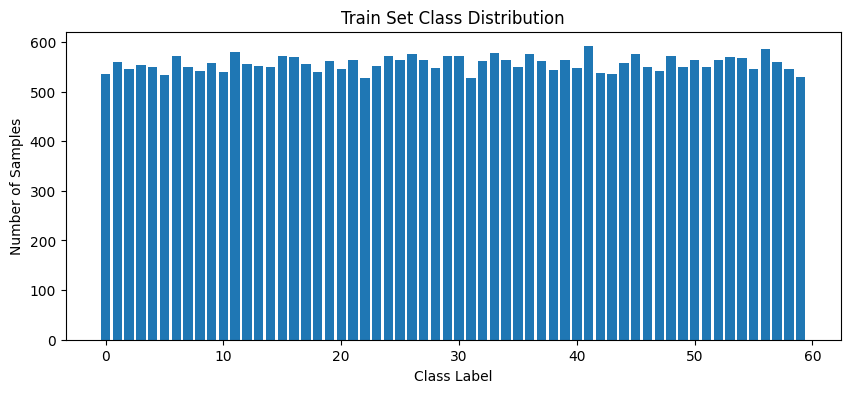

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load training labels
with open(train_label, 'rb') as f:
    sample_names, sample_labels = pickle.load(f)

sample_labels = np.array(sample_labels)

# Print class distribution
unique, counts = np.unique(sample_labels, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"Class {cls}: {cnt} samples")

# Optional: Plot class histogram
plt.figure(figsize=(10,4))
plt.bar(unique, counts)
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Train Set Class Distribution')
plt.show()


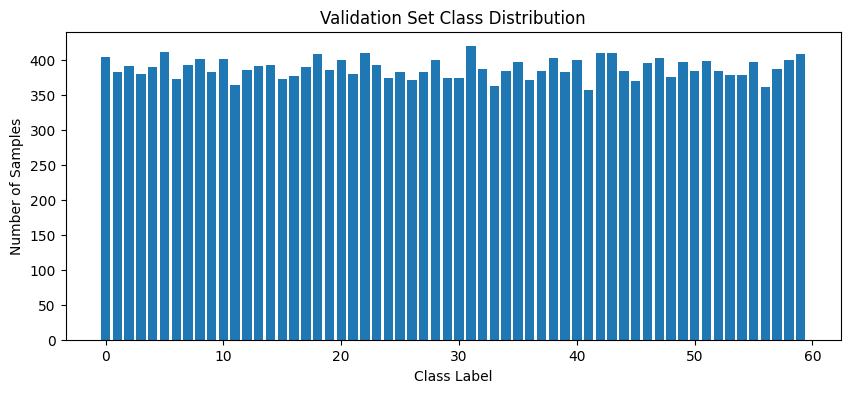

In [ ]:
with open(val_label, 'rb') as f:
    val_names, val_labels = pickle.load(f)

val_labels = np.array(val_labels)

unique_val, counts_val = np.unique(val_labels, return_counts=True)
plt.figure(figsize=(10,4))
plt.bar(unique_val, counts_val)
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Validation Set Class Distribution')
plt.show()


# **Run Training (X-View)**

In [ ]:
import warnings

# Filter out the specific FutureWarning related to GradScaler
warnings.filterwarnings("ignore", category=FutureWarning, message="`torch.cuda.amp.GradScaler(args...)` is deprecated")
# Also filter out FutureWarnings from the torch.cuda.amp module more broadly
warnings.filterwarnings("ignore", category=FutureWarning, module="torch.cuda.amp")
# Add a general filter for all FutureWarnings as a fallback
warnings.filterwarnings("ignore", category=FutureWarning)



Starting AGCN training for X-View...
Epoch  1/90 | Time: 289.8s | LR: 0.006667 | Train Loss: 4.0244 Acc: 0.0687 | Val Loss: 3.1611 Acc: 0.1966 | Confidence: 3.99%
  New best model saved! (Acc: 0.1966)
Epoch  2/90 | Time: 290.7s | LR: 0.013333 | Train Loss: 2.9546 Acc: 0.2467 | Val Loss: 2.4604 Acc: 0.4157 | Confidence: 14.21%
  New best model saved! (Acc: 0.4157)
Epoch  3/90 | Time: 290.0s | LR: 0.020000 | Train Loss: 2.4288 Acc: 0.4235 | Val Loss: 2.2126 Acc: 0.5083 | Confidence: 29.79%
  New best model saved! (Acc: 0.5083)
Epoch  4/90 | Time: 290.0s | LR: 0.026667 | Train Loss: 2.1111 Acc: 0.5394 | Val Loss: 1.8832 Acc: 0.6124 | Confidence: 34.15%
  New best model saved! (Acc: 0.6124)
Epoch  5/90 | Time: 289.5s | LR: 0.033333 | Train Loss: 1.9200 Acc: 0.6104 | Val Loss: 1.7373 Acc: 0.6621 | Confidence: 43.41%
  New best model saved! (Acc: 0.6621)
Epoch  6/90 | Time: 289.5s | LR: 0.040000 | Train Loss: 1.7951 Acc: 0.6564 | Val Loss: 1.6379 Acc: 0.7018 | Confidence: 47.37%
  New best 

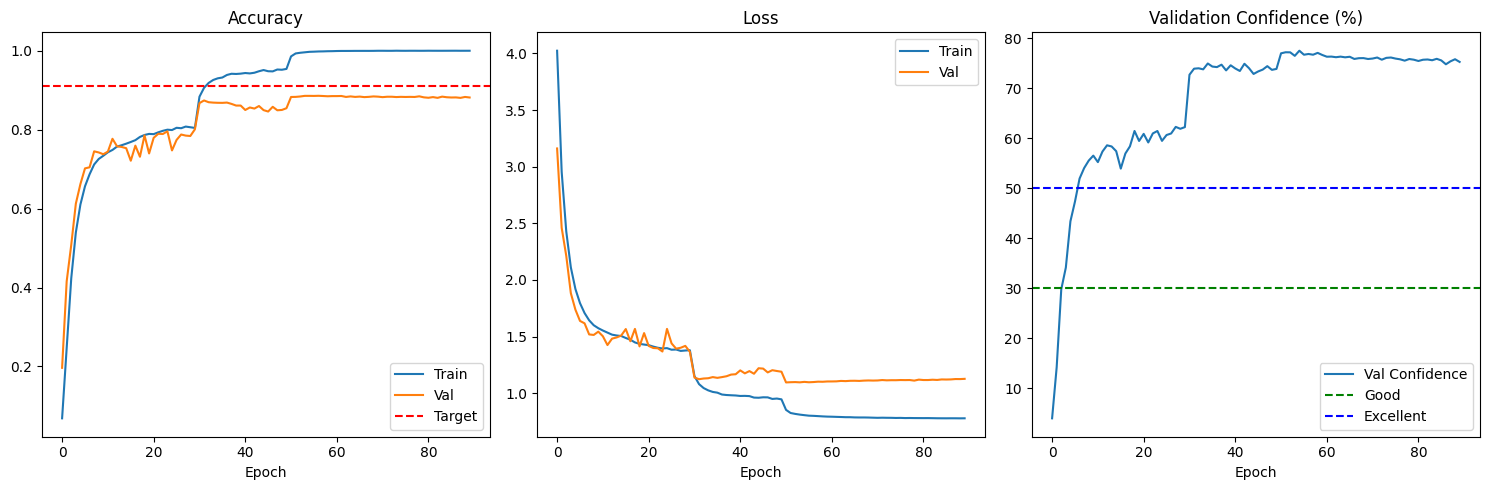


X-View Final Best Validation Accuracy: 0.8857 at Epoch 57


In [ ]:
# Cell 7: Run Training (X-View)
# Update paths for X-View
xview_train_data = '/content/drive/MyDrive/ntu_normalized/xview_train_data_joint.npy'
xview_val_data = '/content/drive/MyDrive/ntu_normalized/xview_val_data_joint.npy'
xview_train_label = '/content/drive/MyDrive/ntu_processed/xview/train/train_label.pkl'
xview_val_label = '/content/drive/MyDrive/ntu_processed/xview/val/val_label.pkl'

print("\nStarting AGCN training for X-View...")
xview_best_acc, xview_best_epoch, xview_history = train_and_evaluate_agcn(
    xview_train_data, xview_train_label,
    xview_val_data, xview_val_label,
    save_path='/content/drive/MyDrive/agcn_xview_enhanced.pth',
    batch_size=64,
    epochs=90,
    patience=35,
    plot_prefix='AGCN_XVIEW'
)
print(f"\nX-View Final Best Validation Accuracy: {xview_best_acc:.4f} at Epoch {xview_best_epoch}")